<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.855 · Modelos avanzados de minería de datos</p>
<p style="margin: 0; text-align:right;">2022-2 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# PEC 2: Métodos no supervisados

A lo largo de esta práctica veremos como aplicar distintas técnicas no supervisadas, así como algunas de sus aplicaciones reales:

 - **[Clustering con distintas estrategias](#ej1)**: k-means y regla del codo, basadas en densidad y jerárquicas.
 - **[Aplicación para comprimir imágenes](#ej2)**: clustering y análisis.
 - **[Aplicación de reducción de dimensionalidad para resolver un problema de optimización](#ej3)**: t-SNE.

<u>Consideraciones generales</u>: 

- La solución planteada no puede utilizar métodos, funciones o parámetros declarados **_deprecated_** en futuras versiones, a excepción de que se indique explícitamente.
- Esta PEC debe realizarse de forma **estrictamente individual**. Cualquier indicio de copia será penalizado con un suspenso (D) para todas las partes implicadas y la posible evaluación negativa de la asignatura de forma íntegra.
- Es necesario que el estudiante indique **todas las fuentes** que ha utilizado para la realización de la PEC. De no ser así, se considerará que el estudiante ha cometido plagio, siendo penalizado con un suspenso (D) y la posible evaluación negativa de la asignatura de forma íntegra.

<u>Formato de la entrega</u>:

- Algunos ejercicios pueden suponer varios minutos de ejecución, por lo que la entrega debe hacerse en **formato notebook** y en **formato html**, donde se vea el código, los resultados y comentarios de cada ejercicio. Se puede exportar el notebook a HTML desde el menú File $\to$ Download as $\to$ HTML.
- Existe un tipo de celda especial para albergar texto. Este tipo de celda os será muy útil para responder a las diferentes preguntas teóricas planteadas a lo largo de la actividad. Para cambiar el tipo de celda a este tipo, en el menú: Cell $\to$ Cell Type $\to$ Markdown.

<div class="alert alert-block alert-info">
<strong>Nombre y apellidos:</strong>
</div>

In [1]:
Kevin Luna Obando

SyntaxError: invalid syntax (3261148613.py, line 1)

Iniciamos la activdad con la carga de las siguientes librerías:

In [23]:
import random

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.cluster import KMeans        # Algoritmos de clustering.
from sklearn import datasets       # Crear datasets.
random_state = 170

%matplotlib inline

<a id="ej1"></a>

## 1. Métodos de *clustering* (5 puntos)

Este ejercicio trata de explorar distintas técnicas de agrupamiento, ajustándolas a distintos conjuntos de datos.

El objetivo es doble: 
- entender la influencia de los parámetros en su comportamiento, 
- y conocer sus limitaciones en la búsqueda de estructuras de datos.

### Generación de los conjuntos de datos

In [3]:
X_blobs, y_blobs = datasets.make_blobs(n_samples=1000, n_features=2, centers=4, cluster_std=1.6, random_state=42)
X_moons, y_moons = datasets.make_moons(n_samples=1000, noise=.07, random_state=42)
X_circles, y_circles = datasets.make_circles(n_samples=1000, factor=.5, noise=.05, random_state=42)

Cada dataset tiene 2 variables: una variable *X* que contiene 2 features (columnas) y tantas filas como muestras. Y una variable *y* que alberga las etiquetas que identifican cada cluster.

A lo largo del ejercicio no se usará la variable *y* (sólo con el objetivo de visualizar). El objetivo es encontrar las estructuras descritas por las variables *y* a través de los distintos modelos de *clustering* conseguir.

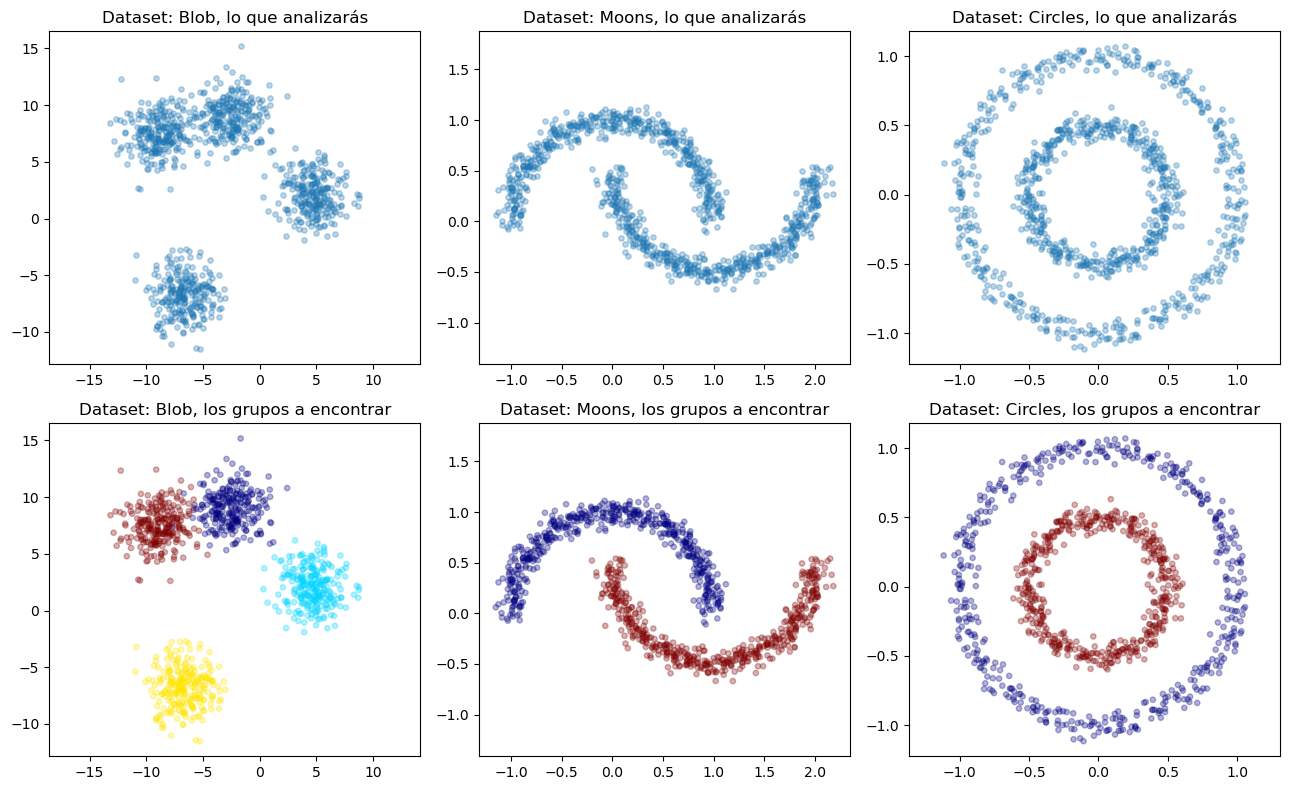

In [3]:
fig, axis = plt.subplots(2, 3, figsize=(13, 8))
for i, (X, y, ax, name) in enumerate(zip([X_blobs, X_moons, X_circles] * 2,
                                         [None] * 3 + [y_blobs, y_moons, y_circles],
                                         axis.reshape(-1),
                                         ['Blob', 'Moons', 'Circles'] * 2)):
    ax.set_title('Dataset: {}, '.format(name) + ('lo que analizarás' if i < 3 else 'los grupos a encontrar'))
    ax.scatter(X[:,0], X[:,1], s=15, c=y, alpha=.3, cmap='jet')
    ax.axis('equal')
plt.tight_layout()

### 1 a. K-means

En este apartado se pide probar el algoritmo *k-means* sobre los tres datasets presentados anteriormente ajustando con los parámetros adecuados y analizar sus resultados.

In [36]:
X, y = X_blobs, y_blobs

Para estimar el número de clusters a detectar por *k-means*. Una técnica para estimar $k$ es, como se explica en la teoría:
> Los criterios anteriores (minimización de distancias intra grupo o maximización de distancias inter grupo) pueden usarse para establecer un valor adecuado para el parámetro k. Valores k para los que ya no se consiguen mejoras significativas en la homogeneidad interna de los segmentos o la heterogeneidad entre segmentos distintos, deberían descartarse.

Lo que popularmente se conocer como *regla del codo*.

Primero es necesario calcular la suma de los errores cuadráticos ([*SSE*](https://bl.ocks.org/rpgove/0060ff3b656618e9136b)) que consiste en la suma de todos los errores (distancia de cada punto a su centroide asignado) al cuadrado.

$$SSE = \sum_{i=1}^{K} \sum_{x \in C_i} euclidean(x, c_i)^2$$

Donde $K$ es el número de clusters a buscar por *k-means*, $x \in C_i$ son los puntos que pertenecen a i-ésimo cluster, $c_i$ es el centroide del cluster $C_i$ (al que pertenece el punto $x$), y $euclidean$ es la [distancia euclídea](https://en.wikipedia.org/wiki/Euclidean_distance).

Este procedimiento realizado para cada posible valor $k$, resulta en una función monótona decreciente, donde el eje $x$ representa los distintos valores de $k$, y el eje $y$ el $SSE$. Intuitivamente se podrá observar un significativo descenso del error, que indicará el valor idóneo de $k$.

**Se pide realizar la representación gráfica de la regla del codo junto a su interpretación, utilizando la librería ```matplotlib``` y la implementación en scikit-learn de [*k-means*](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).**

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> cálculo y visualización de la regla del codo en el dataset Blobs.
</div>

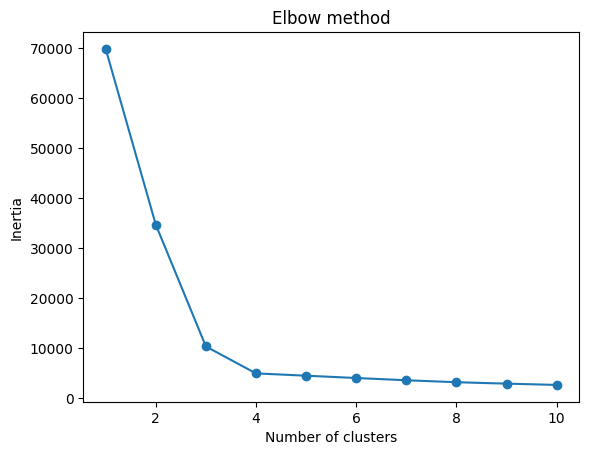

In [37]:
def elbow_method(X):
    inertias = []

    for i in range(1,11):
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)

    plt.plot(range(1,11), inertias, marker='o')
    plt.title('Elbow method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.show()

elbow_method(X)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿qué se interpreta en la gráfica?, ¿Cómo podría mejorarse la elección de $k$?
</div>

La interpretación de la gráfica del método del codo es la siguiente: el eje x representa el número de clusters, mientras que el eje y representa los valores de inercia que miden cuánto se alejan los puntos dentro de un cluster de su centroide. La curva de la gráfica típicamente muestra una caída abrupta al principio y luego comienza a estabilizarse después de un cierto número de clusters. El punto donde la curva comienza a estabilizarse se llama "punto de codo". Este punto indica que agregar más clusters no conduce a una mejora significativa en el rendimiento del clustering, y agregar muy pocos clusters resulta en un rendimiento de clustering deficiente. Por lo tanto, el número óptimo de clusters se estima visualmente al seleccionar el número de clusters en el punto de codo.

En este caso, la curva del método del codo muestra una caída rápida al principio y luego comienza a estabilizarse después de k=3. Esto indica que el rendimiento del clustering no mejora significativamente con un número mayor de clusters y que el número óptimo de clusters para el clustering K-means es 3.

Una manera de mejorar esta elección sería usando otro tipo de método como: el método de Silouette. El cual calcula una media de cuan similares son los puntos dentro de un cluster y cuan diferentes son de los puntos en otros clústeres. La media varia entre -1 y 1, y valores cercanos a 1 indican una buena separacion de clústeres.

In [40]:
from sklearn.metrics import silhouette_score
def silhouette_method(X):
    for i in range(2,11):
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(X)
        cluster=kmeans.labels_
        silouhette_score = silhouette_score(X,cluster)
        print("Silhouette score: {:.3f} (k = {})".format(silouhette_score, i))

silhouette_method(X)

Silhouette score: 0.486 (k = 2)
Silhouette score: 0.423 (k = 3)
Silhouette score: 0.457 (k = 4)
Silhouette score: 0.482 (k = 5)
Silhouette score: 0.510 (k = 6)
Silhouette score: 0.514 (k = 7)
Silhouette score: 0.514 (k = 8)
Silhouette score: 0.516 (k = 9)
Silhouette score: 0.509 (k = 10)


Usando este método podemos observar que tanto k=3 y k=4 son buenas opciones.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> cálculo y visualización de los grupos en el dataset Blobs.
</div>

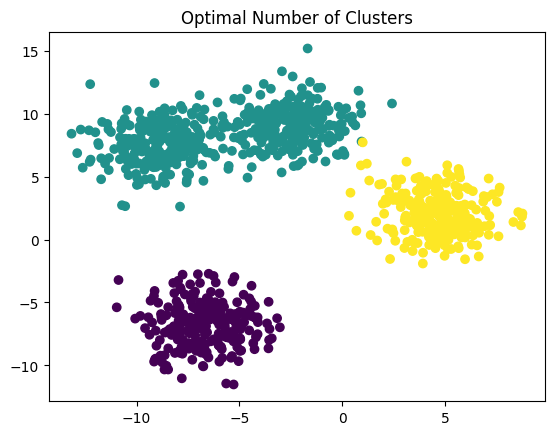

In [32]:
y_pred = KMeans(n_clusters=3).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Optimal Number of Clusters")
plt.show()


<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado. 
</div>

Podemos observar que el número adecuado de clúteres es 4. Uno de los motivos por el cual el metodo del codo no ha funcionado adecuadamente puede ser por el solpamiento de grupos, ya que no se puede observa una clara frontera entre los dos grupos de arriba.
Con una k=4 el clustering resultaría:

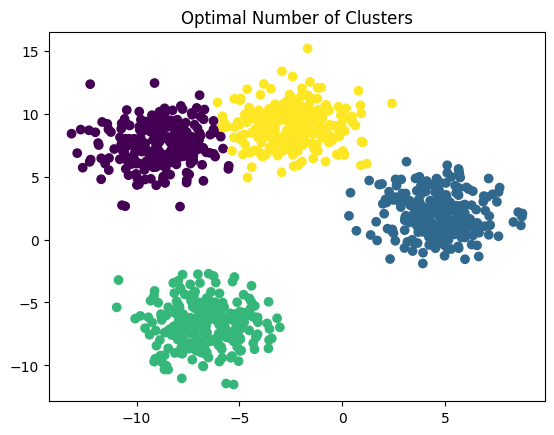

In [33]:
y_pred = KMeans(n_clusters=4).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Optimal Number of Clusters")
plt.show()

In [57]:
X, y = X_moons, y_moons

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> cálculo y visualización de la regla del codo en el dataset Moons.
</div>

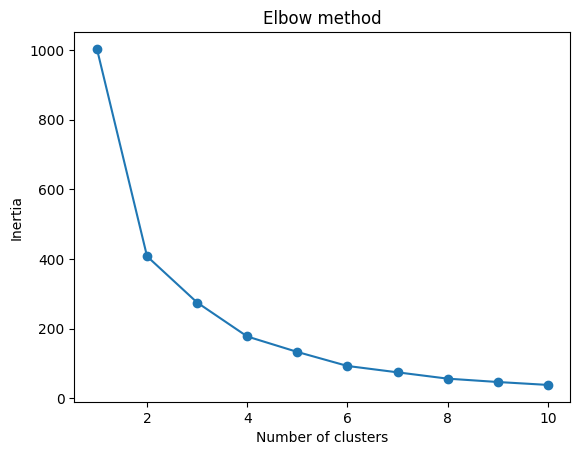

In [58]:
elbow_method(X)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿qué se interpreta en la gráfica?, ¿cómo podría mejorarse la elección de $k$?.  
</div>

En este caso, la curva del método del codo muestra una caída rápida al principio y luego comienza a estabilizarse después de k=2. Esto indica que el rendimiento del clustering no mejora significativamente con un número mayor de clusters y que el número óptimo de clusters para el clustering K-means es 2.
Una manera de mejorar esta elección sería usando otro tipo de método como: el método de Silouette. El cual calcula una media de cuan similares son los puntos dentro de un cluster y cuan diferentes son de los puntos en otros clústeres. La media varia entre -1 y 1, y valores cercanos a 1 indican una buena separacion de clústeres.

In [61]:
silhouette_method(X)

Silhouette score: 0.486 (k = 2)
Silhouette score: 0.421 (k = 3)
Silhouette score: 0.457 (k = 4)
Silhouette score: 0.482 (k = 5)
Silhouette score: 0.510 (k = 6)
Silhouette score: 0.513 (k = 7)
Silhouette score: 0.514 (k = 8)
Silhouette score: 0.516 (k = 9)
Silhouette score: 0.509 (k = 10)


Usando este método podemos observar que tanto k=2 y k=6 son buenas opciones.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> cálculo y visualización de los grupos en el dataset Moons.
</div>

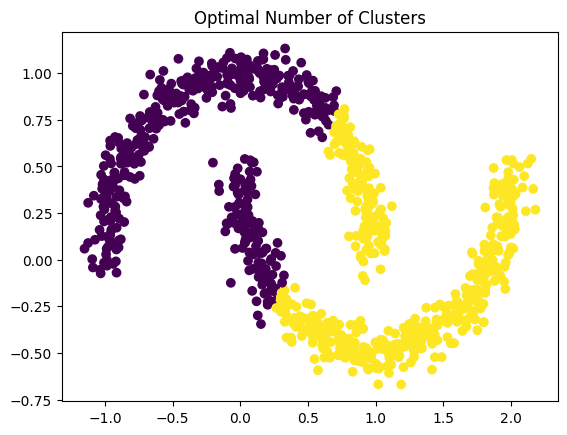

In [60]:
y_pred = KMeans(n_clusters=2).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Optimal Number of Clusters")
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

Cuando los datos no están uniformemente distribuidos en todas las direcciones, es decir, tienen una distribución anisotrópica, el algoritmo K-means puede tener dificultades para agruparlos correctamente. Esto se debe a que K-means minimiza la suma de las distancias cuadradas entre cada punto y su centroide asignado, lo que puede llevar a que algunos puntos se asignen a centroides incorrectos si la distribución de los datos no es esférica.

En este caso, se hace necesario considerar algoritmos de clustering basados en densidad como DBSCAN, ya que estos algoritmos no se basan en la distancia euclidiana para definir los grupos, sino que consideran la densidad de puntos cercanos en el espacio. Debido a esto, los algoritmos basados en densidad son más adecuados para distribuciones anisotrópicas o para datos que no están claramente separados por límites claros o definidos.

In [62]:
X, y = X_circles, y_circles

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> cálculo y visualización de la regla del codo en el dataset Circles.
</div>

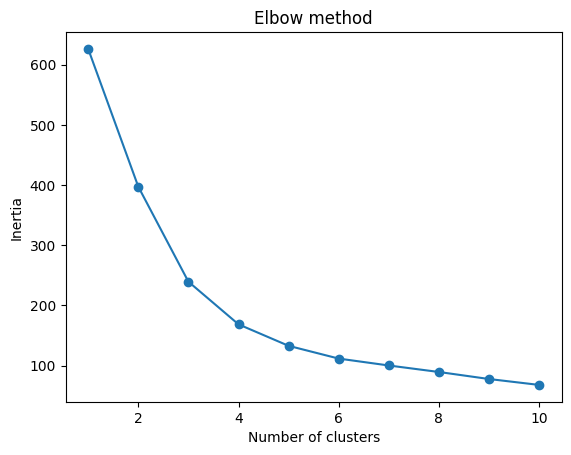

In [63]:
elbow_method(X)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué se interpreta en la gráfica?, ¿cómo podría mejorarse la elección de $k$?.  
</div>

En este caso, la curva del método del codo muestra una caída rápida al principio y luego comienza a estabilizarse después de k=3. Esto indica que el rendimiento del clustering no mejora significativamente con un número mayor de clusters y que el número óptimo de clusters para el clustering K-means es 3.
Una manera de mejorar esta elección sería usando otro tipo de método como: el método de Silouette. El cual calcula una media de cuan similares son los puntos dentro de un cluster y cuan diferentes son de los puntos en otros clústeres. La media varia entre -1 y 1, y valores cercanos a 1 indican una buena separacion de clústeres.

In [50]:
silhouette_method(X)

Silhouette score: 0.353 (k = 2)
Silhouette score: 0.393 (k = 3)
Silhouette score: 0.382 (k = 4)
Silhouette score: 0.361 (k = 5)
Silhouette score: 0.341 (k = 6)
Silhouette score: 0.314 (k = 7)
Silhouette score: 0.354 (k = 8)
Silhouette score: 0.378 (k = 9)
Silhouette score: 0.417 (k = 10)


Usando este método podemos observar k=3 es una buena opción.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> cálculo y visualización de los grupos en el dataset Circles.
</div>

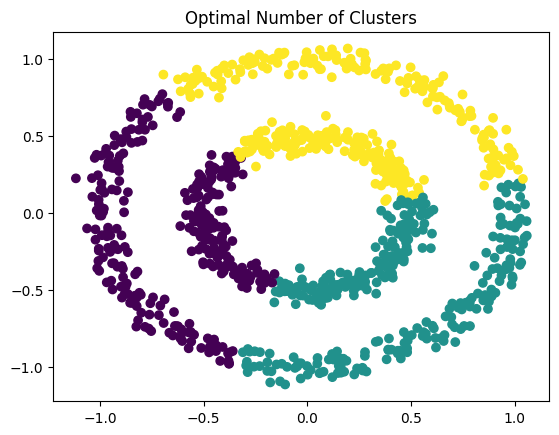

In [64]:
y_pred = KMeans(n_clusters=3).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Optimal Number of Clusters")
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

Debido a que los datos poseen una distribución de datos de dos circunferencias concentricas, K-means no es adecuado para identificar los grupos con precisión, ya que los grupos no se pueden separar claramente con una línea recta. Esto se debe a que K-means es un algoritmo de clustering basado en centroides que funciona mejor cuando los grupos tienen formas más simples y se pueden separar fácilmente con líneas rectas o planos. Por lo tanto, en casos como este, se recomienda el uso de algoritmos de clustering basados en la densidad de los datos, como DBSCAN.

### 1 b. Algoritmos basados en densidad: DBSCAN

En este apartado se pide aplicar clustering por densidad como [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN) a los datasets anteriores para detectar los dos grupos subyacentes.

Ésta es una visualización intuitiva de su funcionamiento: https://www.youtube.com/watch?v=RDZUdRSDOok

In [76]:
X, y = X_blobs, y_blobs

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> prueba la implementación de <a href="http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html">DBSCAN en scikit-learn</a> jugando con los parámetros <i>eps</i> y <i>min_samples</i> para encontrar los grupos (y <i>outliers</i>) del dataset Blobs.
</div>

In [170]:
from sklearn.cluster import DBSCAN
from itertools import product
import seaborn as sns

In [213]:
def dbscan_method(X, eps_values=[0.3],min_samples=[3]):
    DBSCAN_params = list(product(eps_values, min_samples))

    no_of_clusters = []
    DBSCAN_params_new = []

    for p in DBSCAN_params:
        DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(X)
        no_cluster= len(np.unique(DBS_clustering.labels_))

        if no_cluster == 1: 
            #DBSCAN_params.remove(p)
            continue

        DBSCAN_params_new.append(p)
        no_of_clusters.append(no_cluster)
    
    return  no_of_clusters,DBSCAN_params_new

eps_values = np.arange(0.5,8,0.25) # grid eps value
min_samples = np.arange(5,15) #grid min_sample
no_of_clusters,DBSCAN_params_new = dbscan_method(X,eps_values=eps_values,min_samples=min_samples)


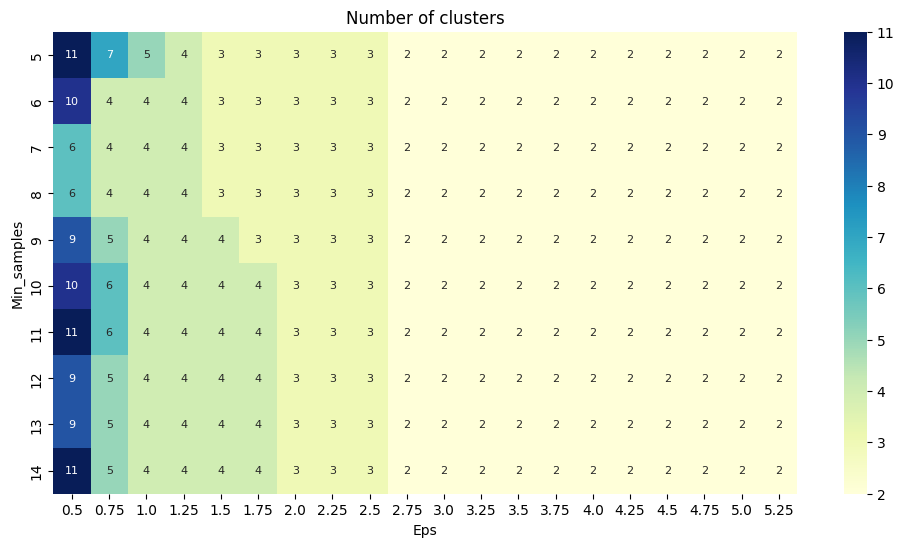

In [216]:
tmp = pd.DataFrame.from_records(DBSCAN_params_new, columns =['Eps', 'Min_samples'])   
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 8}, cmap="YlGnBu", ax=ax)
ax.set_title('Number of clusters')
plt.show()

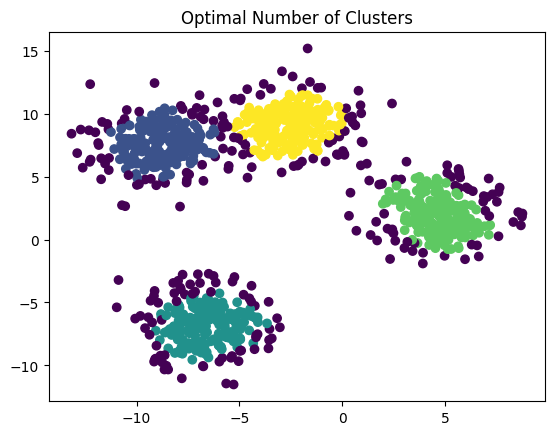

In [241]:
y_pred = DBSCAN(eps=0.75, min_samples=12).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Optimal Number of Clusters")
plt.show()

Usando los hiperparámetros: eps=0.75 y min_samples=12 obtenemos 4 clústeres distintos, además de la identificación de los outliers (puntos en morado).

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

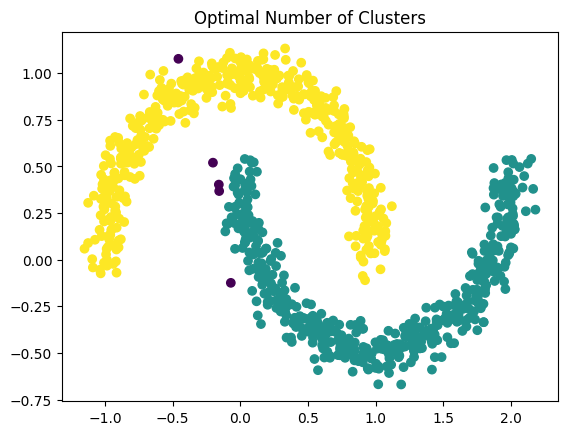

In [251]:
X, y = X_moons, y_moons

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> prueba la implementación de DBSCAN jugando con los parámetros <i>eps</i> y <i>min_samples</i> para encontrar los grupos (y <i>outliers</i>) del dataset Moons.
</div>

In [273]:
eps_values = np.arange(0.1,2,0.05) # grid eps value
min_samples = np.arange(2,8) #grid min_sample
no_of_clusters,DBSCAN_params_new = dbscan_method(X,eps_values=eps_values,min_samples=min_samples)

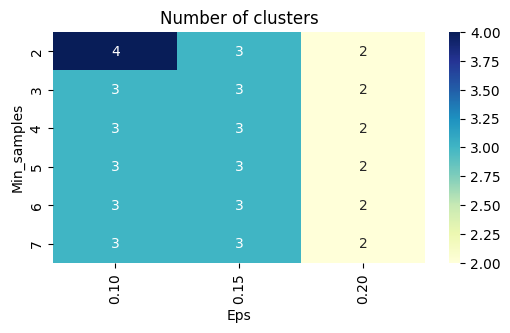

In [278]:
tmp = pd.DataFrame.from_records(DBSCAN_params_new, columns =['Eps', 'Min_samples'])   
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(6,3))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
# Format x-axis decimals
ax.set_xticklabels(['{:.2f}'.format(x) for x in pivot_1.columns])
ax.set_title('Number of clusters')
plt.show()

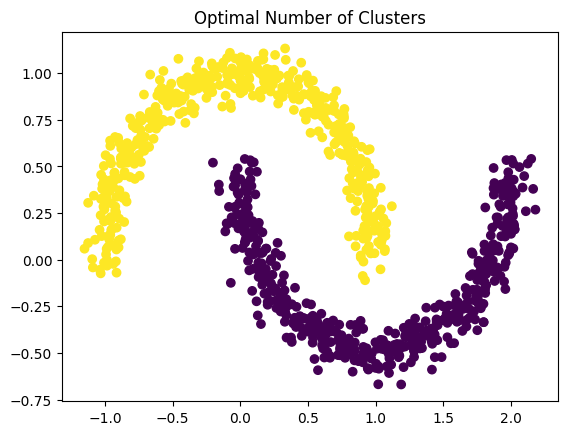

In [279]:
y_pred = DBSCAN(eps=0.2, min_samples=5).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Optimal Number of Clusters")
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

In [280]:
X, y = X_circles, y_circles

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> prueba la implementación de DBScan jugando con los parámetros <i>eps</i> y <i>min_samples</i> para encontrar los grupos (y <i>outliers</i>) del dataset Circles.
</div>

In [284]:
eps_values = np.arange(0.1,3,0.05) # grid eps value
min_samples = np.arange(2,10) #grid min_sample
no_of_clusters,DBSCAN_params_new = dbscan_method(X,eps_values=eps_values,min_samples=min_samples)

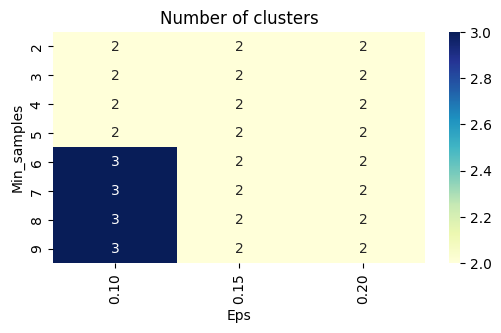

In [285]:
tmp = pd.DataFrame.from_records(DBSCAN_params_new, columns =['Eps', 'Min_samples'])   
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(6,3))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
# Format x-axis decimals
ax.set_xticklabels(['{:.2f}'.format(x) for x in pivot_1.columns])
ax.set_title('Number of clusters')
plt.show()

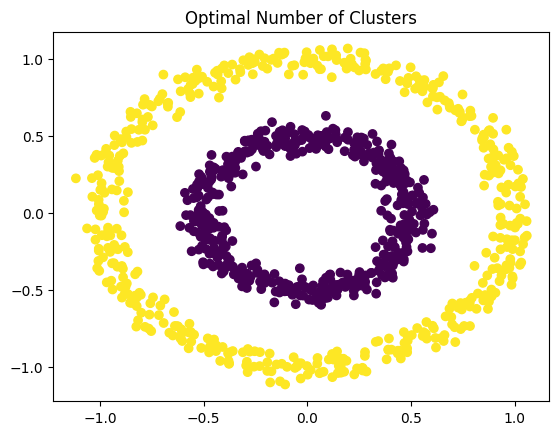

In [289]:
y_pred = DBSCAN(eps=0.2, min_samples=5).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Optimal Number of Clusters")
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

### 1 c. Algoritmos jerárquicos

En este apartado se pide visualizar mediante un [dendrograma](https://en.wikipedia.org/wiki/Dendrogram) la construcción progresiva de los grupos mediante un algoritmo jerárquico aglomerativo (estrategia *bottom-up*). Con ello se pretende encontrar un método gráfico para entender el comportamiento del algoritmo y encontrar los *clusters* deseados en cada dataset.

In [19]:
X, y = X_blobs, y_blobs

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> prueba la implementación de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jerárquico de scipy</a> probando distintos <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criterios de enlace o <i>linkage</i></a> permitiendo identificar los clusters subyacentes (mostrando su resultado) y su dendrograma para el dataset Blobs.<br>
Puedes importar las librerías necesarias para ello.
</div>

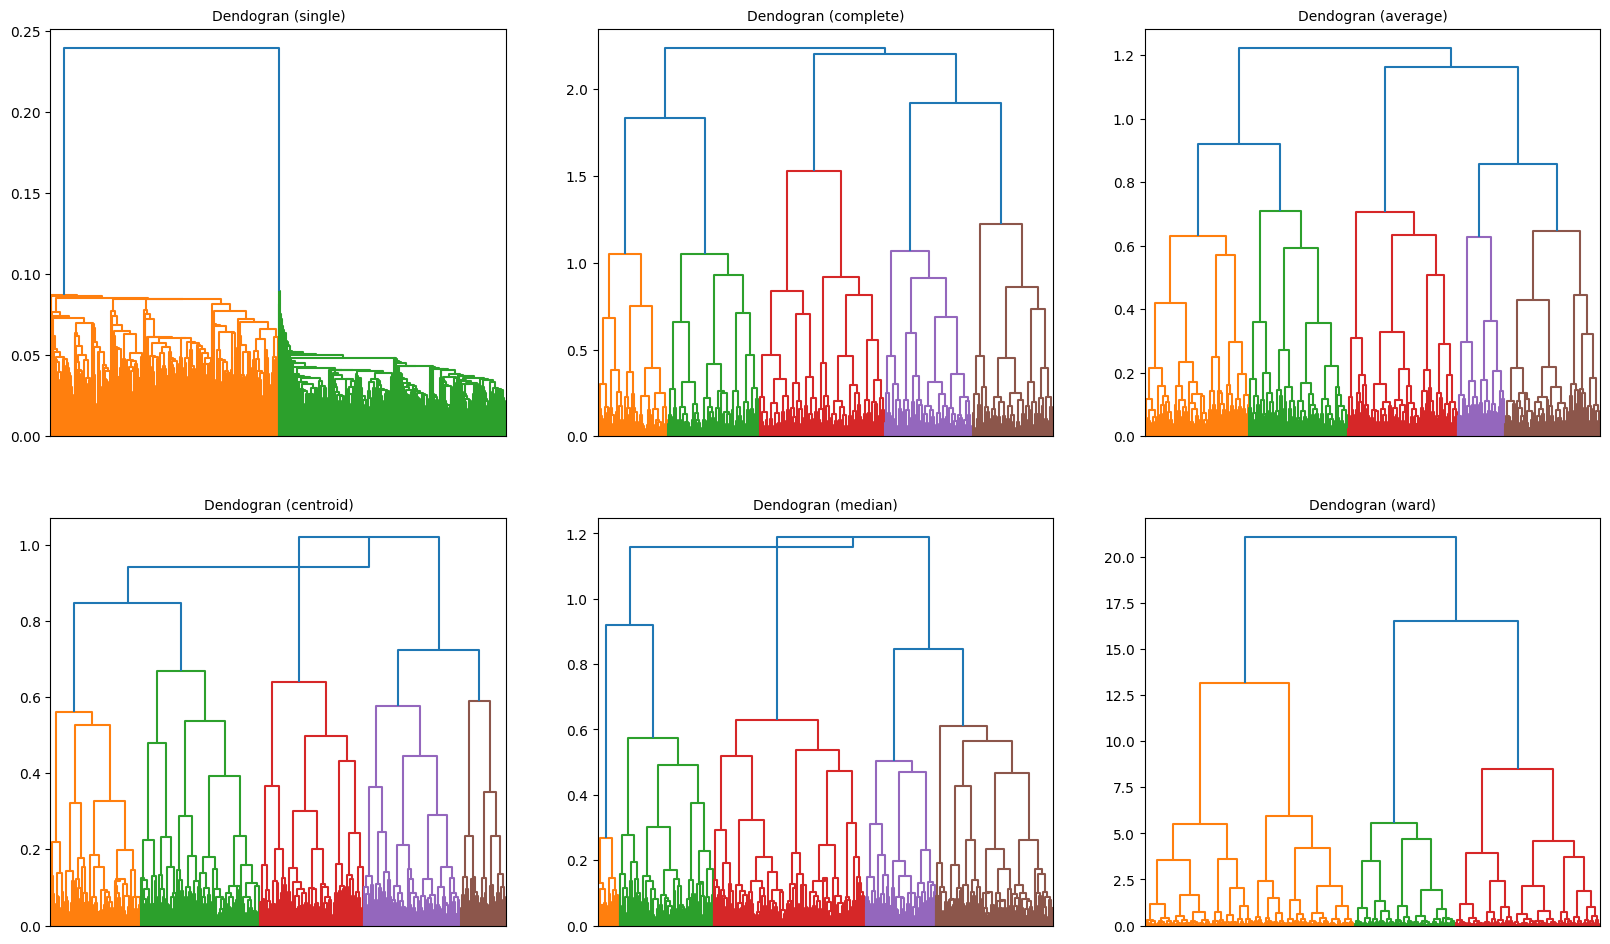

In [299]:
import scipy.cluster.hierarchy as sch

linkages = ['single','complete', 'average','centroid', 'median', 'ward']
plt.figure(figsize=(20,18))
for i,link in enumerate(linkages,1):
    plt.subplot(3,3,i)
    dendrogram = sch.dendrogram(sch.linkage(X, method = link))
    title = 'Dendogran ({})'.format(link)
    plt.title(title, fontsize = 10)
    plt.xticks([])
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> Interpreta el dendrograma y comenta qué criterio de enlace se ha comportado mejor. ¿Por qué?
</div>

In [300]:
X, y = X_moons, y_moons

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
prueba la implementación de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jerárquico de scipy</a> probando distintos <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criterios de enlace o <i>linkage</i></a> permitiendo identificar los clusters subyacentes (mostrando su resultado) y su dendrograma para el dataset Moons.<br>
Puedes importar las librerías necesarias para ello.
</div>

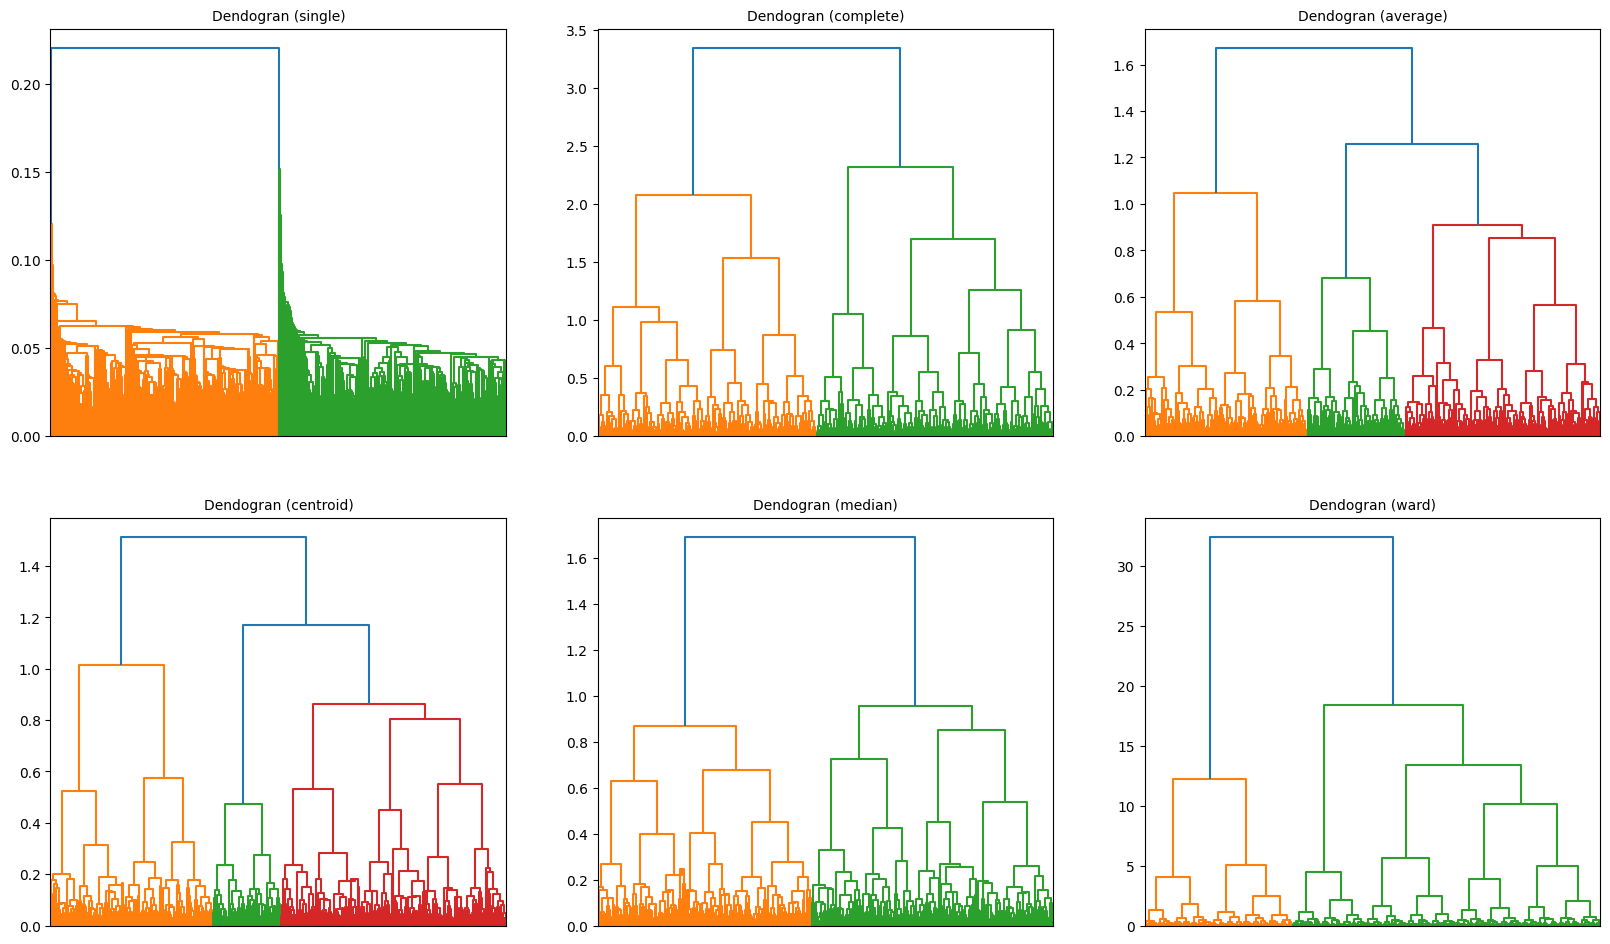

In [301]:
linkages = ['single','complete', 'average','centroid', 'median', 'ward']
plt.figure(figsize=(20,18))
for i,link in enumerate(linkages,1):
    plt.subplot(3,3,i)
    dendrogram = sch.dendrogram(sch.linkage(X, method = link))
    title = 'Dendogran ({})'.format(link)
    plt.title(title, fontsize = 10)
    plt.xticks([])
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> Interpreta el dendrograma y comenta qué criterio de enlace se ha comportado mejor. ¿Por qué?
</div>

In [308]:
X, y = X_circles, y_circles

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
prueba la implementación de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jerárquico de scipy</a> probando distintos <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criterios de enlace o <i>linkage</i></a> permitiendo identificar los clusters subyacentes (mostrando su resultado) y su dendrograma para el dataset Circles.<br>
Puedes importar las librerías necesarias para ello.
</div>

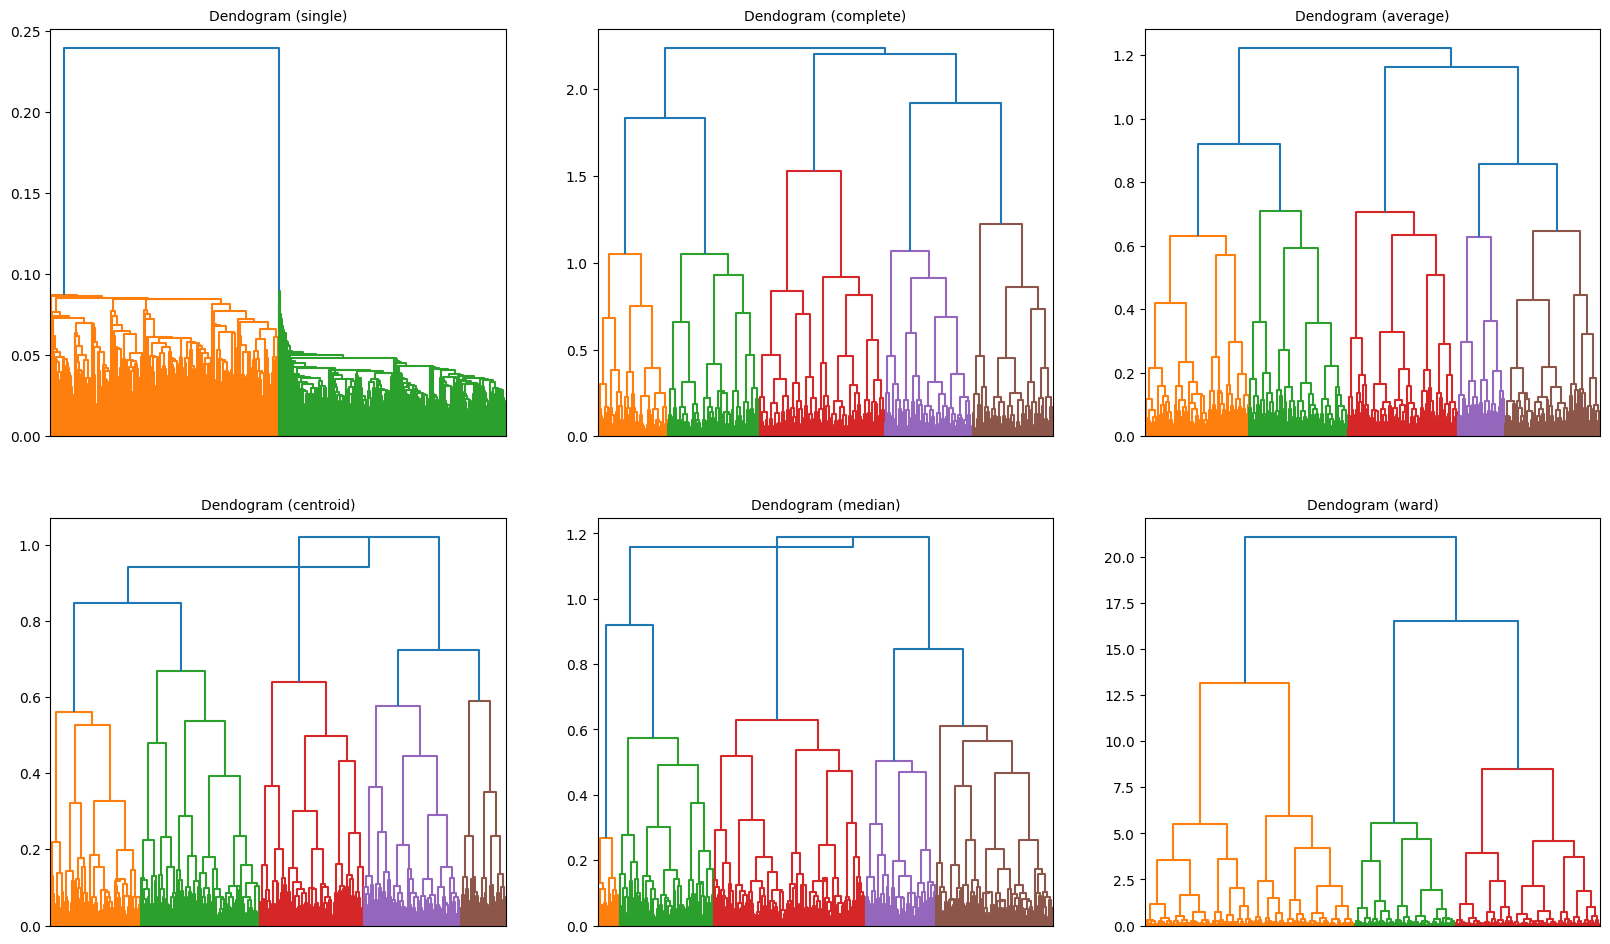

In [309]:
linkages = ['single','complete', 'average','centroid', 'median', 'ward']
plt.figure(figsize=(20,18))
for i,link in enumerate(linkages,1):
    plt.subplot(3,3,i)
    dendrogram = sch.dendrogram(sch.linkage(X, method = link))
    title = 'Dendogram ({})'.format(link)
    plt.title(title, fontsize = 10)
    plt.xticks([])
plt.show()

<function dict.keys>

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> Interpreta el dendrograma y comenta qué criterio de enlace se ha comportado mejor. ¿Por qué?
</div>

<a id="ej2"></a>

## 2. Aplicación para comprimir imágenes (3 puntos)

Las imágenes en color se componen de píxeles que tienen tres componentes (roja, azul y verde), destinando 1 *byte* a cada canal. Pudiendo representar $2^8 = 256$ rojos, verdes y azules. Con un total de $2^{8^{3}} = 2^{24} = 16777216$ colores representables en cada píxel.

Entre mayor sea el número de colores representables, más memoria será necesaria para almacenar la imagen.
Por tanto, una estrategia para comprimir una imagen puede ser disminuir los colores representables en cada píxel, necesitando menos *bits* para guardar el valor de un píxel. Este método no es reversible, es decir, no se puede volver a recuperar la imagen original a partir de la comprimida. Por tanto, este tipo de compresiónse denomina [comprensión con pérdidas](https://es.wikipedia.org/wiki/Algoritmo_de_compresi%C3%B3n_con_p%C3%A9rdida).

Pero ¿cómo seleccionamos los "píxeles parecidos" en la imagen original y determinamos su color en la imagen comprimida?. Una opción es utilizar *k-means* donde **$k$ será el número de colores representables**, los puntos que pertenecen a cada cluster equivaldrían a los "píxeles parecidos" y las coordenadas de los **centroides actuarán como los colores finales** a los que se aproximarán los "píxeles parecidos".

Como resultado del clustering, se obtiene una paleta de colores reducida (coordenadas de los centroides) donde cada píxel de la imagen hará referencia a uno de estos colores (cluster al que pertenece). El uso de paletas de colores o [colores indexados](https://en.wikipedia.org/wiki/Indexed_color) es un recurso empleado por distintos formatos de imagen como *PNG*, *GIF* o *TIFF*.

Si no dispones de la librería ``skimage`` puedes instalarla:
 - Usando conda (si has creado tu entorno virtual con conda): ``conda install scikit-image``
 - Usando pip: ``pip install scikit-image``

Imagen con 65536 pixeles (196608 bytes)


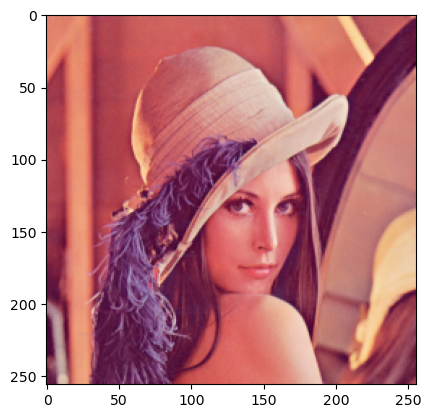

In [26]:
from skimage import io, transform

photo = (transform.resize(
    io.imread('https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png'),
    (256, 256), mode='edge') * 255).astype(np.uint8)
plt.imshow(photo)        # np.array con shape (256, 256, 3), alto por ancho por 3 (los tres canales: rojo, verde y azul), donde cada valor ocupa un byte.
X = photo.reshape(-1, 3) # np.array con shape (65536, 3), cada pixel con sus 3 canales
print('Imagen con {} pixeles ({} bytes)'.format(X.shape[0], X.shape[0] * 3))

Para facilitar la tarea, la imagen anterior está guardada en un *array* con tantas filas como píxeles y columnas como canales (rojo, verde y azul). De forma que cada "muestra" equivale al valor de un píxel.

Se puede volver a recomponer la imagen original con:
```
plt.imshow(X.reshape(photo.shape))
```
Podemos ver cada píxel como un punto en un sistema de coordenadas de 3 dimensiones donde una es su cantidad de rojo, otra su cantidad de verde y por último su cantidad de azul. Por lo que podemos realizar una visualización en 3 dimensiones de los píxeles sobre la que se probará el algoritmo de clustering:

In [27]:
X

array([[225, 136, 125],
       [223, 136, 129],
       [225, 133, 118],
       ...,
       [166,  69,  84],
       [177,  68,  78],
       [182,  72,  80]], dtype=uint8)

Para visualizar la animación de la representación 3D de los píxeles es necesario instalar la librería ``ffmpeg``.

Si tienes un entorno virtual de conda, lo puedes instalar con: ``conda install -c conda-forge ffmpeg``.

**Si tienes un error**, puedes ver una representación estática 2 celdas más adelante.

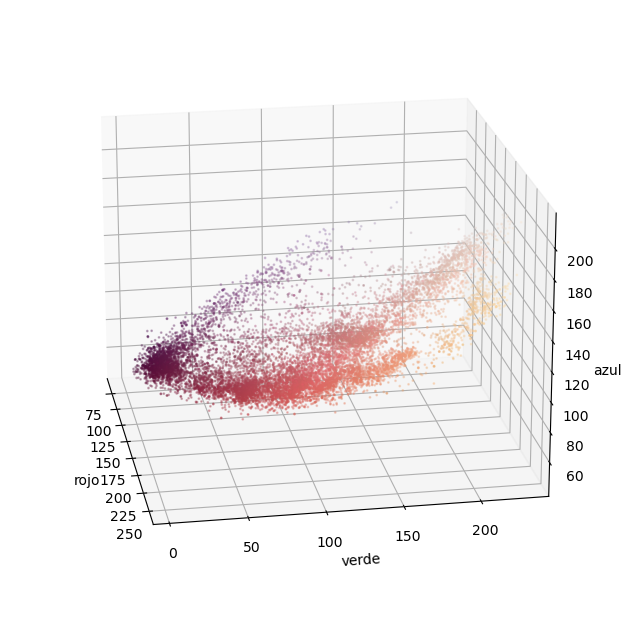

In [28]:
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D

matplotlib.rcParams['animation.html'] = 'html5'

idx = np.random.randint(X.shape[0], size=int(X.shape[0] * .2))
fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig)
ax.scatter(X[idx,0], X[idx,1], X[idx,2], s=1, c=X[idx,:] / 255, alpha=.3)
ax.set_xlabel('rojo')
ax.set_ylabel('verde')
ax.set_zlabel('azul')

def animate(i):
    ax.view_init(elev=20., azim=i)
    return fig,

anim = animation.FuncAnimation(fig, animate, frames=range(0, 360, 10), interval=200, blit=True)
anim

Visualización estática del valor de los píxeles:

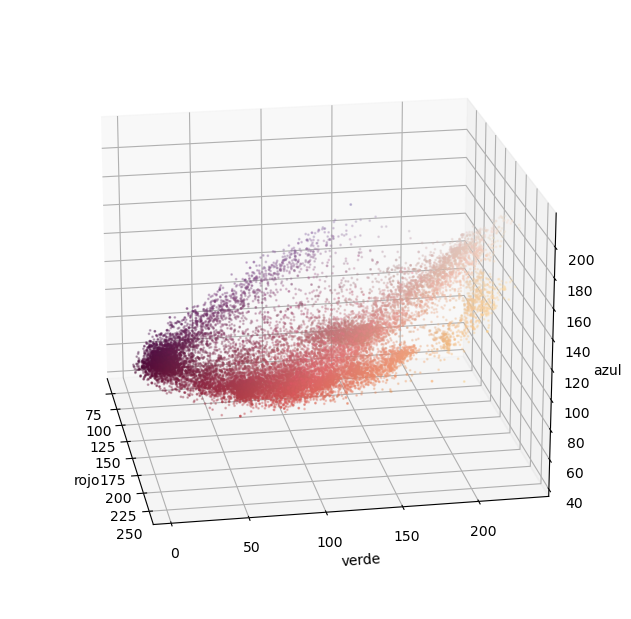

In [29]:
idx = np.random.randint(X.shape[0], size=int(X.shape[0] * .3))
fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig)
ax.scatter(X[idx,0], X[idx,1], X[idx,2], s=1, c=X[idx,:] / 255, alpha=.3)
ax.set_xlabel('rojo')
ax.set_ylabel('verde')
ax.set_zlabel('azul')
ax.view_init(20, 350)
plt.show()

En la visualización anterior se ha representado cada píxel con su color, donde sus coordenadas en los 3 colores oscilan entre 0 (carece de esa componente) y 1. Podemos comprobar como los píxeles en coordenadas (255, 255, 255) son píxeles blancos y los situados en (0, 0, 0) son píxeles negros. También se observan 4 estructuras de píxeles: la pluma del sombrero, el sombrero, la piel de la modelo (Lenna) y el fondo.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> aplicar <i>k-means</i> con <i>k=3</i> a los píxeles de la imagen (puntos con 3 dimensiones de la variable <i>X</i>) y obtener, para cada punto, su centroide más cercano. Y las coordenadas (3 dimensiones) de cada centroide.
</div>

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> asgina a cada punto (píxel de la imagen) el valor de su centroide asociado en lugar de su propio valor.
</div>

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> volver a convertir el resultado en una imagen usando la función <i>reshape</i> (como cuando se creó X) para que vuelva a tener su dimensión de <i>256 x 256</i>. Y mostrarla con <i>imshow</i>.
</div>

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿por qué se ha producido este resultado?, ¿qué relación tiene con el clústering?
</div>

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> realizar el proceso anterior para distintos valores de <i>k</i>: 256, 128, 64, 32, 16, 8, 4 y 2 colores. Mostrar las imágenes e indicar los bytes que ocuparía cada una de las opciones.
</div>

<a id="ej3"></a>

## 3. Aplicación de reducción de dimensionalidad para resolver un problema de optimización: t-SNE (2 puntos)

Como ya se ha visto, el algoritmo [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) ideado por [van der Maaten y Hinton](https://lvdmaaten.github.io/tsne/) difiere de PCA en que no trata de maximizar la varianza explicada. Intuitivamente, t-SNE trata de que la vecindad de un punto en baja dimensionalidad sea la misma que la original (mantenga las distancias). Partiendo de una localización aleatoria de cada punto, corrige su posición de forma iterativa tratando de minimizar la distancia a sus vecinos originales hasta converger.

Para ello, t-SNE dispone de diversos [parámetros](https://distill.pub/2016/misread-tsne/) que pueden modificar drásticamente el resultado. Por lo que se recomienda conocer su funcionamiento antes de aplicar la técnica.

Partiendo de las distancias entre las [provincias de España](https://www.gifex.com/images/0X0/2009-12-02-11305/Provincias_de_Espana.jpg), presentes en el fichero de datos (en *pec2_3.p* un *DataFrame* de *pandas* en formato *pickle* o *pec2_3.csv* en formato *CSV*). Se pide calcular la matriz cuadrada que contenga la distancia de cada provincia contra las demás.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> la matriz debe tener tantas filas y columnas como provincias. Y cada celda debe contener la distancia entre las provincias de esa fila y columna.
</div>

Una vez que se cuenta con la matriz de distancias, *t-SNE* tratará de mantener esas distancias entre los distintos puntos en baja dimensionalidad (en este caso 2 dimensiones). Emplazando los puntos en el plano mientras intenta mantener las distancias indicadas.

Dado que la entrada a [*t-SNE*](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) se le pasa la matriz de distancias, no es necesario que las calcule. Por ello le indicaremos que la métrica a emplear es "precalculada".

Como *t-SNE* es un algoritmo estocástico (dos ejecuciones consecutivas con los mismos datos pueden conducir a resultados diferentes). Se pide realizar el proceso de ajuste con *t-SNE* 100 veces y quedarse con la ejecución con menor error (ver el atributo [*kl_divergence*](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)).

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> jugar con los hiperparámetros de <i>t-SNE</i>, ejecutar 100 veces el ajuste de <i>t-SNE</i> y guardar el resultado de emplazamiento de provincias en el plano de la ejecución con menor error.
</div>

Una vez que se tienen las posiciones de las provincias en el plano, visualizar el resultado y analizar si el emplazamiento de las provincias calculado por *t-SNE* calculado en base a las distancias se parece al real.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> visualizar en un <i>scatter</i> las provincias de la ejecución con menor error, junto con su nombre para poder analizarlo.
</div>

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿se parece a la distribución de provincias real?, ¿por qué?
</div>